# Análise Quantitativa
## ETFs
**Resumo:** Neste trabalho avaliaremos várias métricas e otimizações referentes a *Exchange Traded Funds*, também conhecidos como fundos de investimentos, relacionados ao índice norte-americano (S&P500), inflação do Brasil (IMA-B), fundos imobiliários (IFIX) e criptoativos (Bitcoin e Ethereum). Como  pesos de referência, respectivamente, consideramos: 50%, 30%, 18% e 2%.

Os ETFs usualmente buscam replicar a performance de algum índice, assim tomando uma posição passiva em relação aos ativos que o compõem (independentemente se o índice subir ou cair, o ETF o seguirá).

In [1]:
import pandas as pd
import numpy as np
import pypfopt as pf
import quant_tools as qt                        # módulo de funções quants auxiliares
from datetime import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.graph_objects as go
import plotly.figure_factory as ff
import visuals                                  # módulo de visualização pessoal
from portfolio_class import Portfolio           # classe auxiliar
import joblib as jl
import warnings
warnings.filterwarnings("ignore")

# Dados
## Passado

Iniciaremos a coleta com os dados referentes ao período 10/11/2017 - 02/01/2020. No entanto, como a maioria dos ETFs foi criado há menos de um ano, não há dados suficientes se os coletarmos diretamente. Por isso:

- para simularmos o HASH11 baixaremos os preços do Bitcoin e Ethereum do *Yahoo Finance* e colocaremos 65% no primeiro e 35% no segundo;
- para simularmos o IMAB11 iremos considerar o índice IMA-B, retirados do [Nasdaq Data Link](https://data.nasdaq.com/data/BCB/12466-anbima-market-index-of-the-federal-bonds-tied-to-the-ipca-index-imab) (ex-Quandl);
- para simularmos o ETF do IFIX consideraremos o próprio índice, retirado do [investing.com](https://www.investing.com/indices/bm-fbovespa-real-estate-ifix).

In [2]:
start_past_dt = dt(2017, 11, 10)
end_past_dt = dt(2020, 1, 2)

sp500_past = qt.carteira(
    ['SPXI11'],
    start_past_dt,
    end_past_dt,
    source='yf'
)

criptos_past = qt.carteira(
    ['BTC-USD', 'ETH-USD'],
    start_past_dt,
    end_past_dt,
    source='yf',
    crypto=True
)

hash_weights = np.array([.65, .35])

hash11_past = (criptos_past * hash_weights).sum(axis=1).to_frame()
hash11_past.rename(columns={0: 'HASH11'}, inplace=True)

imab_past = qt.get_quandl('imab', start_past_dt, end_past_dt)

ifix_past = qt.market_index('ifix', start_past_dt, end_past_dt)

etfs_past = pd.concat(
    [sp500_past, imab_past, ifix_past, hash11_past],
    axis=1,
    join='inner'
)

#### Instanciando o Portfolio

Com os dados coletados, instanciamos um objeto da classe auxiliar Portfolio, onde este nos fornece uma forma mais eficiente para o cálculo das métricas e comparações. Quando o declaramos sem as datas, tal como

```python
Portfolio(nome, [tickers])
```
obtemos um objeto com um dataframe de preços vazios. Então o preenchemos com os preços coletados acima, as datas e já podemos inserir os pesos de referência: 50%, 30%, 18% e 2%.

In [3]:
etfs_past_pf = Portfolio('ETFs_Past', ['SPXI11', 'IMAB', 'IFIX', 'HASH11'])
etfs_past_pf.prices = etfs_past
etfs_past_pf.dates = (start_past_dt, end_past_dt)
etfs_past_pf.weights = np.array([.5, .3, .18, .02])

# jl.dump(etfs_past_pf, 'past/etfs_past_pf.pkl')

# etfs_past_pf = jl.load('past/etfs_past_pf.pkl')
# Portfolio.register(etfs_past_pf)
etfs_past_pf.prices.head()

,SPXI11,IMAB,IFIX,HASH11
Date,,,,
2017-11-10,87.199997,5446.463941,2207.94,4406.529636
2017-11-13,87.150002,5439.850593,2209.15,4374.519254
2017-11-14,87.150002,5429.035349,2208.72,4431.408354
2017-11-16,87.500000,5455.660346,2208.78,5232.421866
2017-11-17,86.800003,5475.402647,2211.48,5127.181557


### Retornos e Métricas

Com o objeto criado podemos obter os retornos e as métricas facilmente. Por exemplo,

```python
etfs_past_pf.acm_returns(is_portfolio=False)
```

nos retorna os preços acumulados de cada ativo (se `is_portfolio=True` obtemos o retorno acumulado considerando o Portfolio como um todo, com os pesos fornecidos em `etfs_past_pf.weights`).

Dado o gráfico abaixo, notamos uma alta volatilidade para o SPXI11, em relação ao IMAB e ao IFIX, todos com tendência de alta, e uma extrema volatilidade para HASH11, mas em forte tendência de baixa. 2018 foi um ano de grande correção por parte do Bitcoin, devido ao efeito manada ao qual foi sujeito em 2017, com a grande atenção que chamou nas mídias nessa época.

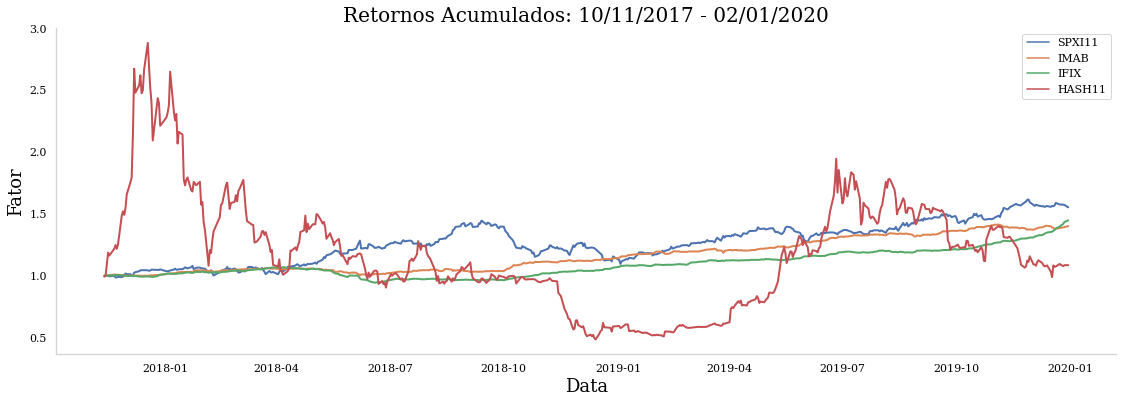

In [7]:
start_past = start_past_dt.strftime('%d/%m/%Y')
end_past = end_past_dt.strftime('%d/%m/%Y')

titles = [
    f'Retornos Acumulados: {start_past} - {end_past}',
    'Data',
    'Fator'
]

qt.plot_lines([etfs_past_pf.acm_returns(is_portfolio=False)], titles, name='acm_returns')

Através do método

```python
portfolio.volatilities(is_portfolio=False)
```

obtemos as volatilidades diária, mensal e anual dos ativos que compõem o portfólio, se `is_portfolio=False`, ou do portfólio como um todo (onde o cálculo agora envolve a correlações entre os ativos e a distribuição de pesos, vide mais abaixo), se `is_portfolio=True`. Para uma comparação mais clara e para visualizarmos o efeito da baixa correlação, unimos as volatilidades do portfólio com as dos ativos e observamos como as volatilidades do SPXI11 e HASH11 são mitigadas.

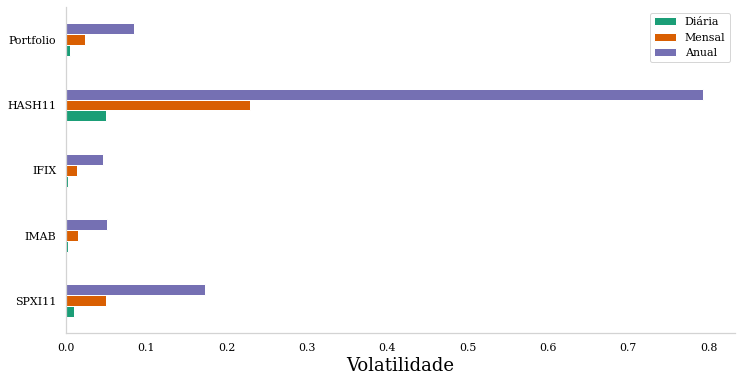

In [36]:
df = etfs_past_pf.volatilities(is_portfolio=False).copy()
df = df.T
df['Portfolio'] = etfs_past_pf.volatilities(is_portfolio=True)['Volatilidade']
df = df.T

df.plot.barh(
    figsize=(12, 6),
    color=['#1b9e77', '#d95f02', '#7570b3']
)
plt.xlabel('Volatilidade');
del df

A baixa volatilidade do portfólio é traduzida em baixos parâmetros de risco, como VaR (percentil dos piores retornos, i.e., os mais negativos) e CVaR (média desses retornos).

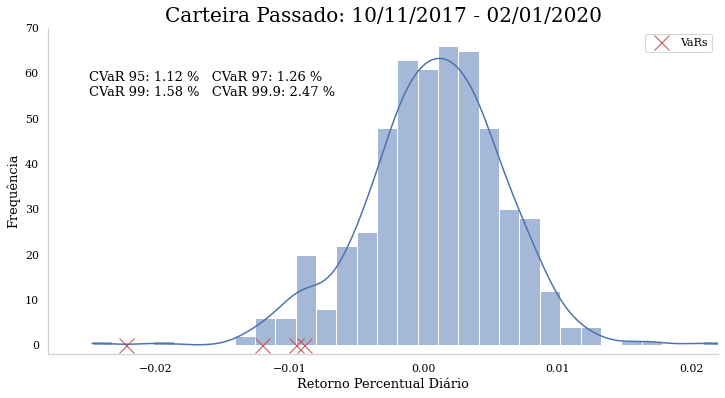

In [18]:
vars_hist_past = etfs_past_pf.var()
cvars_hist_past = etfs_past_pf.cvar()

# seaborn
fig, ax = plt.subplots(figsize=(12, 6))

sns.histplot(
    data=etfs_past_pf.d_returns()['Retornos'],
    kde=True
)

plt.plot(
    vars_hist_past.values,
    [0, 0, 0, 0],
    'x',
    markersize=15,
    color='r',
    label='VaRs'
)

plt.axis([-.028, .022, -2, 70])
t = (
    f'CVaR 95: {cvars_hist_past.loc[95] * 100:.2f} %'
    f'   CVaR 97: {cvars_hist_past.loc[97] * 100:.2f} %'
    f'\nCVaR 99: {cvars_hist_past.loc[99] * 100:.2f} %'
    f'   CVaR 99.9: {cvars_hist_past.loc[99.9] * 100:.2f} %'
)

ax.text(-.025, 55, t, fontdict={'size': 13})

plt.legend()
plt.title(f'Carteira Passado: {start_past} - {end_past}')
plt.xlabel('Retorno Percentual Diário', fontdict={'size': 13})
plt.ylabel('Frequência', fontdict={'size': 13});

##### Comparação entre os VaRs
Como mencionado, o VaR e o CVaR calculados acima são oriundos, exclusivamente, dos retornos históricos. Como estes são sensíveis ao período escolhido, realizamos uma comparação entre os demais tipos: paramétrico (obtido através da distribuição normal) e paramétrico ajustado (obtido através de uma correção---de Cornish-Fisher---da distribuição, quando esta não é normal). Na grande maioria dos casos, a distribuição de retornos de ativos não assume uma forma normal, por isso é valioso também utilizarmos o VaR paramétrico ajustado. (Na verdade, este também é um dos principais motivos pelo qual o desvio padrão não carrega uma clara interpretação sobre risco.) Aliás, como o gráfico a seguir apresenta, há uma grande diferença entre os três quando consideramos o pior cenário, de 99.9%.

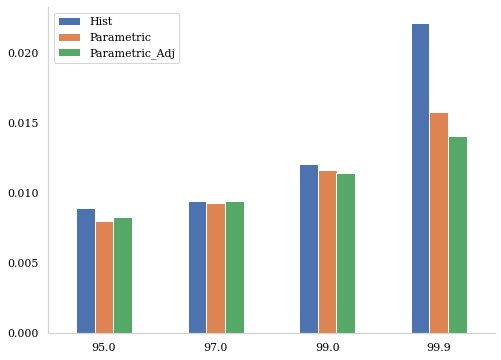

In [50]:
etfs_past_pf.all_vars().plot.bar(figsize=(8, 6), rot=0);

##### Benchmark

Para realizarmos um benchmark e demais cálculos, baixamos o Índice Bovespa do mesmo período e instanciamos seu Portfolio. Com a sintaxe

```python
p1.benchmark([portfolios])
```

obtemos um benchmark de p1 com todos os portfólios na lista. Como destaque, observamos uma volatilidade muito maior do Ibovespa.

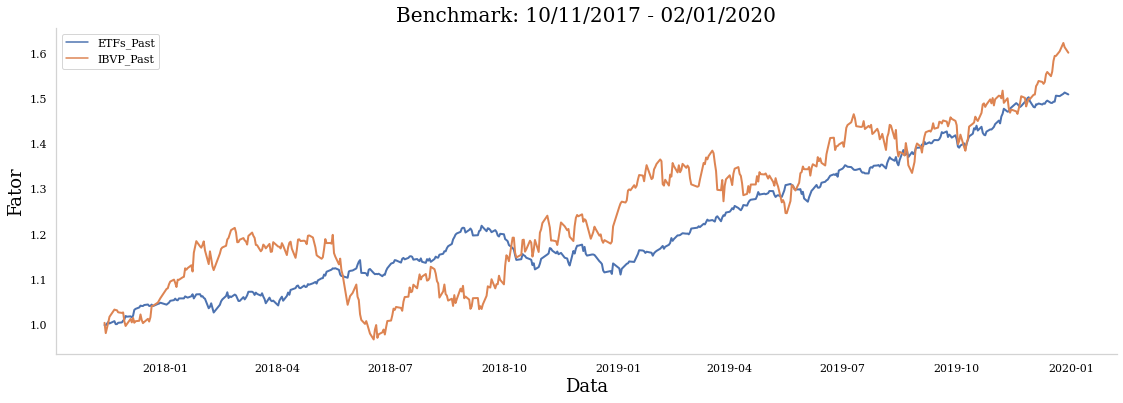

In [33]:
# baixando os dados
ibvp_past = qt.market_index('bvsp', start_past_dt, end_past_dt)

# armazenando em disco
# jl.dump(ibvp_past, 'past/ibvp_past.pkl')

# carregando-o e transformando em Portfolio
# ibvp_past = jl.load('past/ibvp_past.pkl')

ibvp_past_pf = Portfolio('IBVP_Past', ['IBVP'])
ibvp_past_pf.prices = ibvp_past
ibvp_past_pf.dates = (start_past_dt, end_past_dt)
Portfolio.register(ibvp_past_pf)

etfs_past_pf.benchmark([ibvp_past_pf])

In [35]:
ibvp_past_pf.volatilities()

,Diária,Mensal,Anual
BVSP,0.012641,0.057929,0.200672


Comparamos agora o drawdown móvel, de 21 dias (mensal), entre o portfólio de ETFs e o Ibovespa. De fato, o primeiro mostra-se muito mais seguro ao investidor; o que também pode ser visto pelas demais métricas, em especial, o índice de Sharpe, onde aqui precisamos da taxa livre de risco: a taxa Selic.

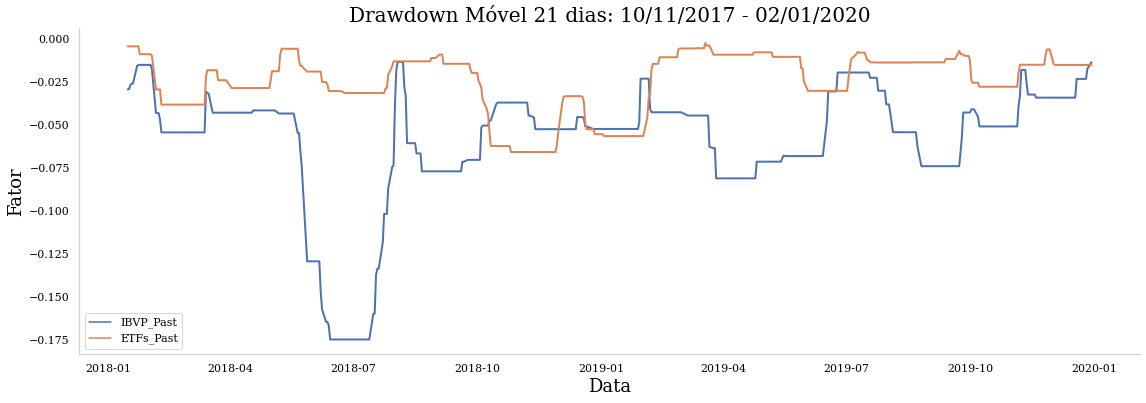

In [53]:
window = 21
titles = [
    f'Drawdown Móvel {window} dias: {start_past} - {end_past}',
    'Data',
    'Fator'
]

qt.plot_lines(
    [
        ibvp_past_pf.rol_drawdown(window=window, is_number=False),
        etfs_past_pf.rol_drawdown(window=window, is_number=False)
    ],
    titles=titles
)

In [54]:
selic_a_past = qt.selic(start_past_dt, end_past_dt, is_number=True)
# jl.dump(selic_a_past, 'past/selic_a_past.pkl')
# selic_a_past = jl.load('past/selic_a_past.pkl')
etfs_past_pf.metrics(
    risk_free_rate=selic_a_past,
    window=21,
    benchmark=ibvp_past_pf
)

,ETFs_Past
Retorno anual,0.206355
Volatilidade anual,0.085152
Ind. Sharpe,2.088154
Ind. Sortino,3.069374
Beta,0.042261
Skewness,-0.125514
Ex_Curtose,-0.562827
VaR 99.9 (d),0.022171
CVaR 99.9 (d),0.024728
Max. Drawdown (21),-0.065576


#### Correlações

É interessante também olharmos para como os ativos (ETFs) estão correlacionados entre si. Neste caso, a maior correlação presente é entre o IFIX e o IMAB com 26%, de onde podemos concluir que o portfólio demonstra uma boa diversificação. Em particular, destacamos a correlação negativa entre as ações americanas e a inflação brasileira (SPXI11 e IMAB).

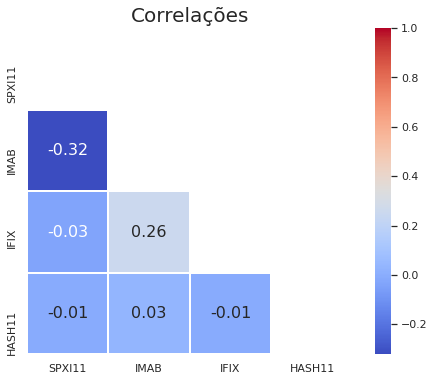

In [55]:
qt.plot_heat_sns(etfs_past_pf.d_returns(is_portfolio=False), size=(8, 6))

## Futuro

Realizamos o mesmo processo, mas agora com dados referente ao período 03/01/2020 - 22/12/2021.

In [20]:
start_fut_dt = dt(2020, 1, 3)
end_fut_dt = dt(2021, 12, 22)

criptos_fut = qt.carteira(
    ['BTC-USD', 'ETH-USD'],
    start_fut_dt,
    end_fut_dt,
    source='yf',
    crypto=True
)

hash_weights = np.array([.65, .35])
hash11_fut = (criptos_fut * hash_weights).sum(axis=1).to_frame()
hash11_fut.rename(columns={0: 'HASH11'}, inplace=True)

sp500_fut = qt.carteira(
    ['SPXI11'],
    start_fut_dt,
    end_fut_dt,
    source='yf'
)

imab_fut = qt.get_quandl('imab', start_fut_dt, end_fut_dt)

ifix_fut = qt.market_index('ifix', start_fut_dt, end_fut_dt)

etfs_fut = pd.concat(
    [sp500_fut, imab_fut, ifix_fut, hash11_fut],
    axis=1,
    join='inner'
)

### Instanciando o Portfolio

In [56]:
etfs_fut_pf = Portfolio('ETFs_Fut', ['SPXI11', 'IMAB', 'IFIX', 'HASH11'])
etfs_fut_pf.prices = etfs_fut
etfs_fut_pf.dates = (start_fut_dt, end_fut_dt)
etfs_fut_pf.weights = np.array([.5, .3, .18, .02])

# jl.dump(etfs_fut_pf, 'future/etfs_fut_pf.pkl')

# etfs_fut_pf = jl.load('future/etfs_fut_pf.pkl')
# Portfolio.register(etfs_fut_pf)
etfs_fut_pf.prices.head()

,SPXI11,IMAB,IFIX,HASH11
Date,,,,
2020-01-03,137.330002,7615.494840,3253.76,4821.134878
2020-01-06,138.059998,7580.705969,3249.50,5100.498959
2020-01-07,137.649994,7585.211334,3239.81,5356.640446
2020-01-08,138.369995,7606.034730,3183.95,5301.351162
2020-01-09,140.190002,7618.900994,3167.49,5170.039059


### Retornos e Métricas

Em contraste com o período anterior, onde o HASH11 apresentou uma queda significativa, vemos o contrário: uma alta em torno de 800%, devido a uma necessidade maior por parte da digitalização, sendo uma consequência da pandemia do COVID-19. O mercado de FIIs, em contrapartida, foi muito afetado pela mesma e ainda segue descontado.

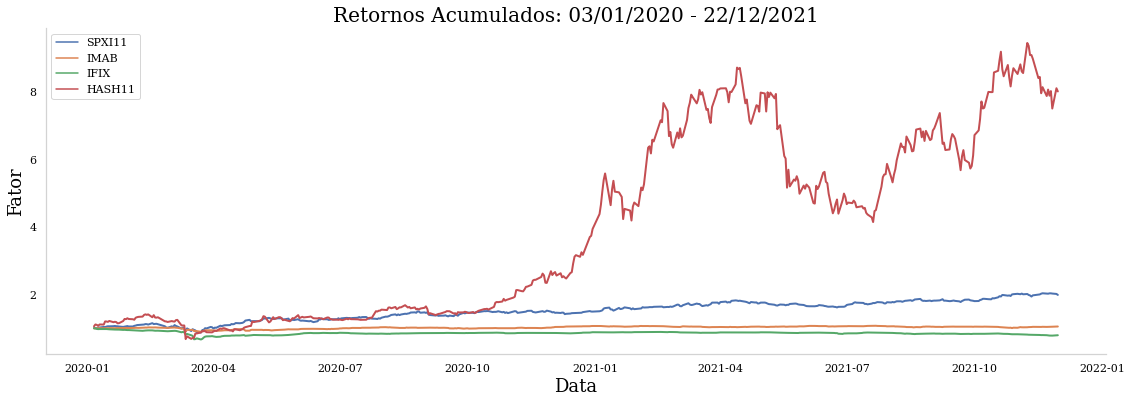

In [9]:
start_fut = start_fut_dt.strftime('%d/%m/%Y')
end_fut = end_fut_dt.strftime('%d/%m/%Y')

titles = [
    f'Retornos Acumulados: {start_fut} - {end_fut}',
    'Data',
    'Fator'
]

qt.plot_lines([etfs_fut_pf.acm_returns(is_portfolio=False)], titles)

Neste período posterior, percebemos um aumento da volatilidade para todos os ativos, com um realce maior ao SPXI, levando o portfólio a uma volatilidade em torno de 20%. Sendo a voliatlidade do período anterior de 8%, temos um aumento significativo advindo da pandemia.

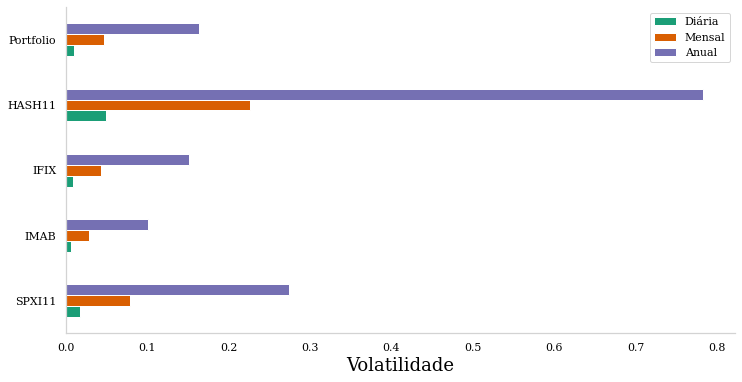

In [57]:
df = etfs_fut_pf.volatilities(is_portfolio=False).copy()
df = df.T
df['Portfolio'] = etfs_fut_pf.volatilities(is_portfolio=True)['Volatilidade']
df = df.T

df.plot.barh(
    figsize=(12, 6),
    color=['#1b9e77', '#d95f02', '#7570b3']
)
plt.xlabel('Volatilidade');
del df

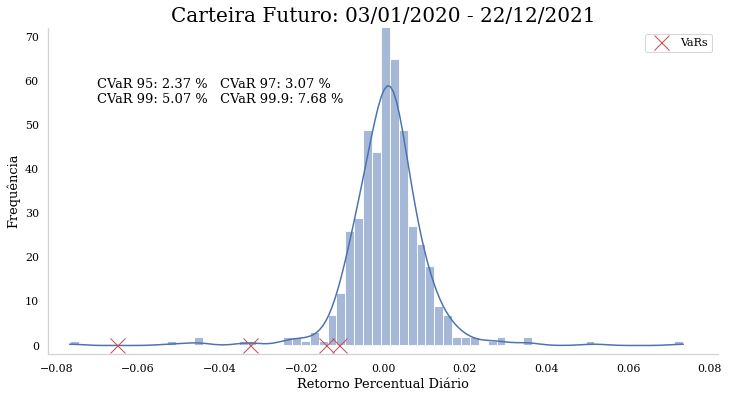

In [22]:
vars_hist_fut = etfs_fut_pf.var()
cvars_hist_fut = etfs_fut_pf.cvar()

# seaborn
fig, ax = plt.subplots(figsize=(12, 6))

sns.histplot(
    data=etfs_fut_pf.d_returns()['Retornos'],
    kde=True
)

plt.plot(
    vars_hist_fut.values,
    [0, 0, 0, 0],
    'x',
    markersize=15,
    color='r',
    label='VaRs'
)

plt.axis([-.082, .082, -2, 72])
t = (
    f'CVaR 95: {cvars_hist_past.loc[95] * 100:.2f} %'
    f'   CVaR 97: {cvars_hist_past.loc[97] * 100:.2f} %'
    f'\nCVaR 99: {cvars_hist_past.loc[99] * 100:.2f} %'
    f'   CVaR 99.9: {cvars_hist_past.loc[99.9] * 100:.2f} %'
)

ax.text(-.07, 55, t, fontdict={'size': 13})

plt.legend()
plt.title(f'Carteira Futuro: {start_fut} - {end_fut}')
plt.xlabel('Retorno Percentual Diário', fontdict={'size': 13})
plt.ylabel('Frequência', fontdict={'size': 13});

##### Comparação entre os VaRs

Aqui notamos mais claramente a diferença entre os tipos de VaRs, e como os efeitos de cauda são mais expressivos para distribuições não-normais.

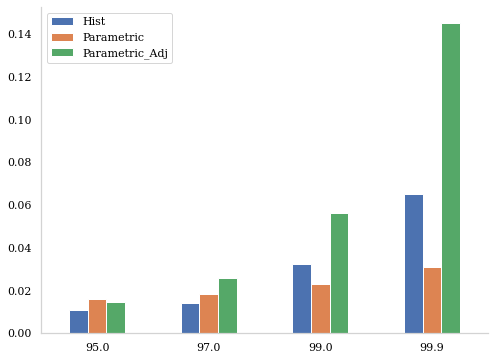

In [12]:
etfs_fut_pf.all_vars().plot.bar(figsize=(8, 6), rot=0);

#### Benchmark

Em relação ao benchmark, observe como o cenário nacional foi seriamente afetado. A retomada do Ibovespa, ilustrada em abril/2020 - junho/2021, não foi capaz de se manter no final de 2021, devido à incertezas políticas e à alta da taxa de juros. Em contraste observamos o portfolio de ETFs, mais focado no mercado internacional, com uma queda não tão brusca, recuperando-se rapidamente e ainda em forte tendência de alta.

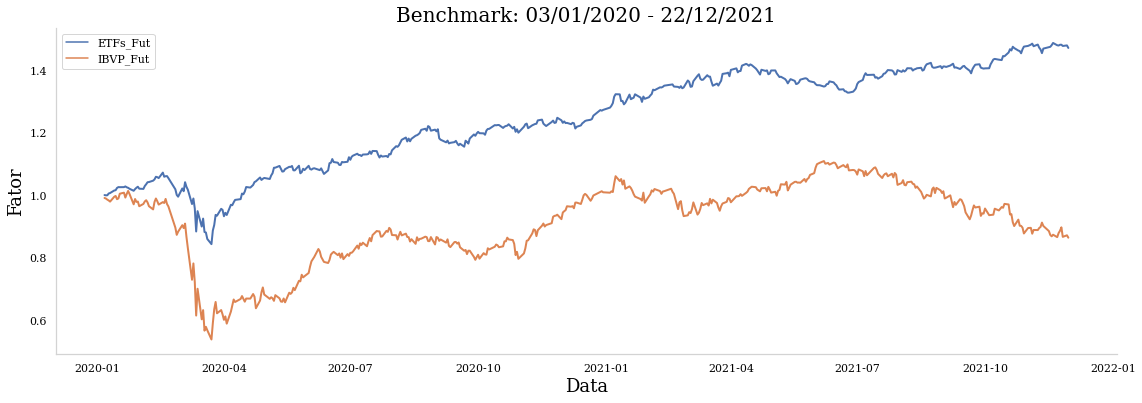

In [63]:
# baixando os dados
ibvp_fut = qt.market_index('bvsp', start_fut_dt, end_fut_dt)

# jl.dump(ibvp_fut, 'future/ibvp_fut.pkl')
# ibvp_fut = jl.load('future/ibvp_fut.pkl')

ibvp_fut_pf = Portfolio('IBVP_Fut', ['IBVP'])
ibvp_fut_pf.prices = ibvp_fut
ibvp_fut_pf.dates = (start_fut_dt, end_fut_dt)
Portfolio.register(ibvp_fut_pf)

etfs_fut_pf.benchmark([ibvp_fut_pf])

Com os drawdowns vemos as quedas de forma mais nítida.

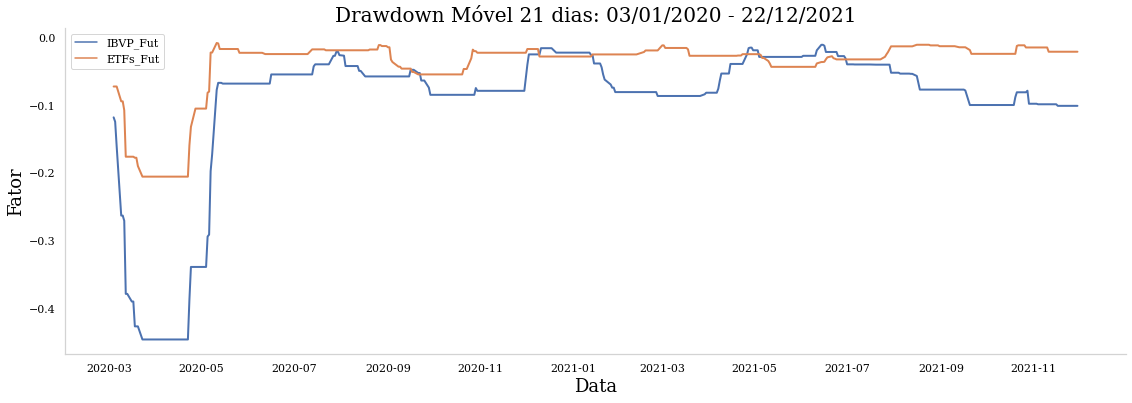

In [25]:
window = 21
titles = [
    f'Drawdown Móvel {window} dias: {start_fut} - {end_fut}',
    'Data',
    'Fator'
]

qt.plot_lines(
    [
        ibvp_fut_pf.rol_drawdown(window=window, is_number=False),
        etfs_fut_pf.rol_drawdown(window=window, is_number=False)
    ],
    titles=titles
)

Apesar da pandemia, o portfólio de ETFs obteve um retorno anual superior, de 24.88%, ao período anterior, mas também uma volatilidade elevada, de 16.38%.

In [64]:
selic_a_fut = qt.selic(start_fut_dt, end_fut_dt, is_number=True)
# jl.dump(selic_a_fut, 'future/selic_a_fut.pkl')
# selic_a_fut = jl.load('future/selic_a_fut.pkl')
etfs_fut_pf.metrics(
    risk_free_rate=selic_a_fut,
    window=21,
    benchmark=ibvp_fut_pf
)

,ETFs_Fut
Retorno anual,0.248798
Volatilidade anual,0.16372
Ind. Sharpe,1.412797
Ind. Sortino,1.630708
Beta,0.288612
Skewness,-0.492891
Ex_Curtose,12.668246
VaR 99.9 (d),0.065087
CVaR 99.9 (d),0.076786
Max. Drawdown (21),-0.204838


## Simulação

Uma vez calculadas as métricas dos períodos, adentraremos na simulação. Simularemos 20.000 combinações de pesos diferentes, com a seguinte restrição: no nosso portfólio com quatro ativos, manteremos o peso máximo do HASH11 em 2%; portanto, ao gerarmos os pesos, geraremos três (referentes aos outros ativos) de forma aleatória, e então combiná-los-emos com o peso de 2% do HASH11. Isto é, dado que geramos $(w_1, w_2, w_3)$ aleatoriamente, o peso final do portfólio será dado por $0.98 \times (w_1, w_2, w_3) + 0.02 \times 1$. Incluímos esta restrição, pois assumimos um investidor consevador que não deseja se expôr aos criptoativos.

In [66]:
%%time

# listas para armazenarmos as quantidades de interesse,
# como retorno, peso, variação e indíce de Sharpe
cart_returns = []
peso_acoes = []
cart_vols = []
sharpe = []

# estabelecendo o número de ativos e o número de carteiras a serem geradas,
# neste caso 20.000
n_ativos = len(etfs_past_pf.tickers)
n_carts = 20_000

# quantidade de anos para anualizarmos o retorno
n_days = etfs_past_pf.prices.shape[0]
n_years = n_days / 252

# retornos não-anualizados (totais)
# e covariância
a_returns_past = etfs_past_pf.total_returns(scaled=False)
cov_past = etfs_past_pf.covariance()

# peso máximo em criptoativos
p = .02

# loop de n_carts valores aleatórios para a geração de várias combinações
# no entanto, não queremos nenhuma carteira com mais de 2% em HASH11
# por isso, geraremos pesos aleatórios para os 3 primeiros ETFs e impôr
# que estes sejam 98% da carteira total, com os 2% restantes em HASH11
for _ in range(n_carts):
    peso = np.random.random(n_ativos - 1)

    # normalizando-os
    peso /= np.sum(peso)

    # impondo a restrição
    peso = np.append(peso * (1 - p), np.array([1]) * p)

    ret = (1 + a_returns_past.dot(peso)) ** (1 / n_years) - 1

    vol = qt.vol(peso, cov_past, annual=True)

    s = qt.sharpe(ret, vol, selic_a_past)

    cart_returns.append(ret)
    peso_acoes.append(peso)
    cart_vols.append(vol)
    sharpe.append(s)


# transformando as listas em arrays
cart_returns = np.array(cart_returns)
peso_acoes = np.array(peso_acoes)
cart_vols = np.array(cart_vols)

# substituindo os índices negativos por 0
sharpe = np.where(np.array(sharpe) > 0, sharpe, 0)

CPU times: user 1.33 s, sys: 0 ns, total: 1.33 s
Wall time: 1.33 s


Agruparemos os resultados em um único dataframe e, entre todos os portfólios gerados, coletaremos o de máximo índice de Sharpe e o de mínima volatilidade.

In [67]:
carteira = {
    'Retorno': cart_returns,
    'Volatilidade': cart_vols,
    'Ind. Sharpe': sharpe
}


# loop que adiciona cada ticker pertencente a 'tickers', com seus respectivos pesos
# (obtidos na célula anterior), à 'carteira'
for k, ticker in enumerate(etfs_past_pf.tickers):
    carteira[ticker] = [p[k] for p in peso_acoes]


cart_aux = pd.DataFrame(carteira)
cols = ['Retorno', 'Volatilidade', 'Ind. Sharpe'] + [t for t in etfs_past_pf.tickers]
cart_aux = cart_aux[cols]


# carteiras de mínima volatilidade e maior índice de Sharpe
carteira_min_vol = qt.find_port_min_vol(cart_aux)
carteira_max_sr = qt.find_port_max_sr(cart_aux)

Podemos visualizá-los num plot retorno x volatilidade e observar a formação da fronteira eficiente.

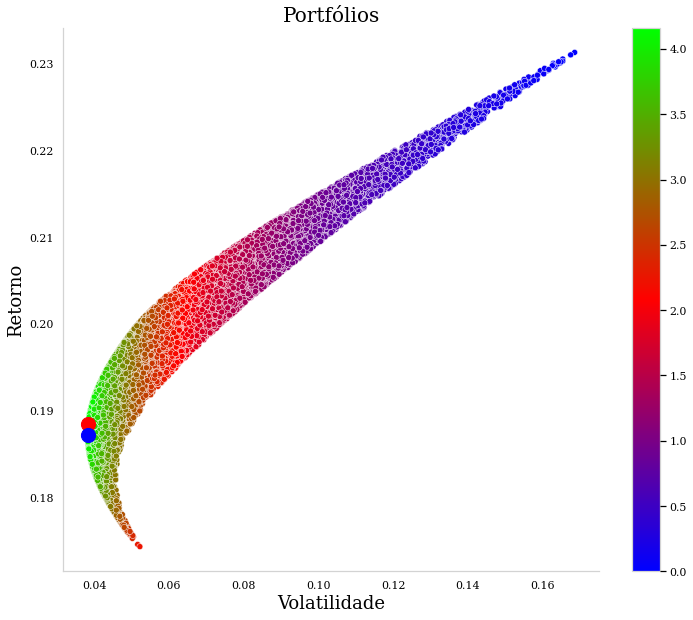

In [68]:
qt.plot_portfolios(cart_aux)

Dado que temos os portfólios da geração aleatória, transformá-los-emos em objetos da classe `Portfolio` com a síntaxe

```python
p2 = p1.transfer(
    name,
    weights
)
```

O método `transfer` copia os dados de `p1` (tickers, preços, pesos e datas) para `p2` e, como a classe não permite objetos de mesmo nome, fornecemos ao último um novo nome `name`. Por fim, atualizamos seus pesos para os desejados: aqueles obtidos na simulação. Este método é muito útil quando desejamos comparar portfólios de mesmos ativos, mesmos períodos, mas pesos diferentes.

In [69]:
etfs_sim_min_vol = etfs_fut_pf.transfer(
    'Sim. Min. Vol.',
    carteira_min_vol.loc[etfs_past_pf.tickers, 'Valores'].values
)

etfs_sim_max_sr = etfs_fut_pf.transfer(
    'Sim. Max. Sharpe',
    carteira_max_sr.loc[etfs_past_pf.tickers, 'Valores'].values
)

# jl.dump(etfs_sim_min_vol, 'future/etfs_sim_min_vol_pf.pkl')
# jl.dump(etfs_sim_max_sr, 'future/etfs_sim_max_sr_pf.pkl')

# etfs_sim_min_vol = jl.load('future/etfs_sim_min_vol_pf.pkl')
# Portfolio.register(etfs_sim_min_vol)

# etfs_sim_max_sr = jl.load('future/etfs_sim_max_sr_pf.pkl')
# Portfolio.register(etfs_sim_max_sr)

## Otimizações

Dados os portfólios obtidos por simulação, queremos compará-los com os obtidos pela otimização. Para isso precisamos dos retornos esperados e de um modelo de risco.

### Estimando Retornos
- Média Histórica

In [70]:
a_returns_fut = etfs_fut_pf.total_returns(scaled=False)

ret_past_mean = pf.expected_returns.mean_historical_return(
    prices=etfs_past_pf.prices,
    compounding=True
)

qt.error_metrics(y_true=a_returns_fut, y_pred=ret_past_mean)

MAE: 2.0651183144568543
RMSE: 3.5171313230631513


- Média Exponencial: a ser utilizada.

In [71]:
ret_past_ema = pf.expected_returns.ema_historical_return(
    prices=etfs_past_pf.prices,
    compounding=True
)

qt.error_metrics(y_true=a_returns_fut, y_pred=ret_past_ema)

MAE: 2.0376870419546806
RMSE: 3.393315076725878


- Modelo CAPM

In [72]:
selic_d_past = (1 + selic_a_past) ** (1/252) - 1

ret_past_capm = pf.expected_returns.capm_return(
    prices=etfs_past_pf.prices,
    market_prices=ibvp_past,
    risk_free_rate=selic_d_past
)

qt.error_metrics(y_true=a_returns_fut, y_pred=ret_past_capm)

MAE: 2.0502942882762696
RMSE: 3.519797513771548


### Modelos de Risco

In [74]:
# sample covariance
samplecov_past = pf.risk_models.sample_cov(etfs_past_pf.prices)
samplecov_fut = pf.risk_models.sample_cov(etfs_fut_pf.prices)

print(f'M.A.E. para sample covariance: {qt.mae_cov(samplecov_past, samplecov_fut)} %')

# semicovariance
# selic_a_fut = jl.load('future/selic_a_fut.pkl')
selic_d_fut = (1 + selic_a_fut) ** (1/252) - 1

semicov_past = pf.risk_models.semicovariance(
    prices=etfs_past_pf.prices,
    benchmark=selic_d_fut
)
semicov_fut = pf.risk_models.semicovariance(
    prices=etfs_fut_pf.prices,
    benchmark=selic_d_fut
)

print(f'M.A.E. para semi covariance: {qt.mae_cov(semicov_past, semicov_fut)} %')

# exponential
expcov_past = pf.risk_models.exp_cov(prices=etfs_past_pf.prices)
expcov_fut = pf.risk_models.exp_cov(prices=etfs_fut_pf.prices)

print(f'M.A.E. para exponential covariance: {qt.mae_cov(expcov_past, expcov_fut)} %')

# ledoit wolf
lwcov_past = pf.risk_models.CovarianceShrinkage(etfs_past_pf.prices).ledoit_wolf()
lwcov_fut = pf.risk_models.CovarianceShrinkage(etfs_fut_pf.prices).ledoit_wolf()

print(f'M.A.E. para Ledoit Wolf covariance: {qt.mae_cov(lwcov_past, lwcov_fut)} %')

M.A.E. para sample covariance: 2.25 %
M.A.E. para semi covariance: 1.26 %
M.A.E. para exponential covariance: 3.09 %
M.A.E. para Ledoit Wolf covariance: 2.71 %


Através da média exponencial e do modelo de Ledoit-Wolf, construíremos as otimizações. Como elas têm uma certa tendência em zerar alguns pesos, e, com base nos pesos de referência, colocaremos as restrições de, no mínimo:

- 40% em SPXI11
- 20% em IMAB
- 15% em IFIX
- 3% em HASH11

Uma vez realizada a otimização, armazenaremos as métricas e compararemos todas no final desta seção.

### Mínima Volatilidade

In [89]:
model = pf.EfficientFrontier(
    expected_returns=ret_past_ema,
    cov_matrix=lwcov_past
)

# restrições
for t, p in zip(etfs_past_pf.tickers, [.4, .2, .15, .03]):
    stock = model.tickers.index(t)
    model.add_constraint(lambda w: w[stock] >= p)

model.min_volatility()

OrderedDict([('SPXI11', 0.4),
             ('IMAB', 0.3801849322163978),
             ('IFIX', 0.1898150677836022),
             ('HASH11', 0.03)])

In [90]:
pesos_min_vol = np.array(
    list(model.clean_weights().values())
)

etfs_opt_min_vol = etfs_fut_pf.transfer(
    'Opt. Min. Vol.',
    pesos_min_vol
)

model.portfolio_performance(verbose=True, risk_free_rate=selic_a_past)

Expected annual return: 24.9%
Annual volatility: 7.6%
Sharpe Ratio: 2.88


(0.24893427148274574, 0.07642283312225043, 2.883826377525944)

In [91]:
print(
      f'Beta da carteira {etfs_opt_min_vol.name}: '
      f'{round(etfs_opt_min_vol.beta(ibvp_fut_pf), 6)}\n'
)

qt.comparison(
      vol_opt=etfs_opt_min_vol.volatility(),
      vol_eq=etfs_fut_pf.volatility(),
      ret_opt=etfs_opt_min_vol.portfolio_return(),
      ret_eq=etfs_fut_pf.portfolio_return(),
      risk_free_rate=selic_a_fut
)

Beta da carteira Opt. Min. Vol.: 0.280898

Volatlidade com os pesos otimizados: 14.649999999999999 %
Volatilidade com os pesos iguais: 16.37 %
Diferença percentual: + 10.507 %

Retorno com os pesos otimizados: 22.59 %
Retorno com os pesos iguais: 24.88 %
Diferença percentual: - 9.2042 %

Índice de Sharpe com os pesos otimizados: 1.4226
Índice de Sharpe com os pesos iguais: 1.413 
Diferença percentual: + 0.6794 %



### Máximo Índice de Sharpe

In [92]:
model = pf.EfficientFrontier(
    expected_returns=ret_past_ema,
    cov_matrix=lwcov_past
)

for t, p in zip(etfs_past_pf.tickers, [.4, .2, .15, .03]):
    stock = model.tickers.index(t)
    model.add_constraint(lambda w: w[stock] >= p)

model.max_sharpe(risk_free_rate=selic_a_past)

OrderedDict([('SPXI11', 0.4), ('IMAB', 0.2), ('IFIX', 0.37), ('HASH11', 0.03)])

In [93]:
pesos_max_sr = np.array(
    list(model.clean_weights().values())
)

etfs_opt_max_sr = etfs_fut_pf.transfer(
    'Opt. Max. Sharpe',
    pesos_max_sr
)

model.portfolio_performance(verbose=True, risk_free_rate=selic_a_past)

Expected annual return: 27.5%
Annual volatility: 7.8%
Sharpe Ratio: 3.15


(0.2750974509902945, 0.07827572561474544, 3.149806144554125)

In [94]:
print(
      f'Beta da carteira {etfs_opt_max_sr.name}: '
      f'{round(etfs_opt_max_sr.beta(ibvp_fut_pf), 6)}\n'
)

qt.comparison(
      vol_opt=etfs_opt_max_sr.volatility(),
      vol_eq=etfs_fut_pf.volatility(),
      ret_opt=etfs_opt_max_sr.portfolio_return(),
      ret_eq=etfs_fut_pf.portfolio_return(),
      risk_free_rate=selic_a_fut
)

Beta da carteira Opt. Max. Sharpe: 0.290876

Volatlidade com os pesos otimizados: 15.36 %
Volatilidade com os pesos iguais: 16.37 %
Diferença percentual: + 6.1698 %

Retorno com os pesos otimizados: 20.01 %
Retorno com os pesos iguais: 24.88 %
Diferença percentual: - 19.574 %

Índice de Sharpe com os pesos otimizados: 1.1888
Índice de Sharpe com os pesos iguais: 1.413 
Diferença percentual: - 15.8669 %



### Retorno e Risco Eficiente

In [95]:
model = pf.EfficientFrontier(
    ret_past_ema,
    lwcov_past
)

for t, p in zip(etfs_past_pf.tickers, [.4, .2, .15, .03]):
    stock = model.tickers.index(t)
    model.add_constraint(lambda w: w[stock] >= p)

# maximizando o retorno para um risco de 20%
model.efficient_risk(target_volatility=.2)

OrderedDict([('SPXI11', 0.4000000000579478),
             ('IMAB', 0.2000000000306395),
             ('IFIX', 0.369999999767934),
             ('HASH11', 0.0300000001434785)])

Notamos que os pesos desta otimização são iguais aos pesos da otimização anterior. Por isso, deixá-los-emos de lado e passaremos para a pŕoxima.

In [96]:
model = pf.EfficientFrontier(
    ret_past_ema,
    lwcov_past
)

for t, p in zip(etfs_past_pf.tickers, [.4, .2, .15, .03]):
    stock = model.tickers.index(t)
    model.add_constraint(lambda w: w[stock] >= p)

# minimizando o risco para um retorno de 25%
model.efficient_return(target_return=.25)

OrderedDict([('SPXI11', 0.4),
             ('IMAB', 0.3728452959696966),
             ('IFIX', 0.1971547040303034),
             ('HASH11', 0.03)])

In [97]:
pesos_min_risk_ret = np.array(
    list(model.clean_weights().values())
)

etfs_min_risk_ret = etfs_fut_pf.transfer(
    'Min. Risk Ret. 25%',
    pesos_min_risk_ret
)
del pesos_min_risk_ret

model.portfolio_performance(verbose=True, risk_free_rate=selic_a_past)

Expected annual return: 25.0%
Annual volatility: 7.6%
Sharpe Ratio: 2.90


(0.25000000000000006, 0.07642594474294154, 2.8976535555475285)

In [98]:
print(
      f'Beta da carteira {etfs_min_risk_ret.name}: '
      f'{round(etfs_min_risk_ret.beta(ibvp_fut_pf), 6)}\n'
)

qt.comparison(
      vol_opt=etfs_min_risk_ret.volatility(),
      vol_eq=etfs_fut_pf.volatility(),
      ret_opt=etfs_min_risk_ret.portfolio_return(),
      ret_eq=etfs_fut_pf.portfolio_return(),
      risk_free_rate=selic_a_fut
)

Beta da carteira Min. Risk Ret. 25%: 0.281304

Volatlidade com os pesos otimizados: 14.67 %
Volatilidade com os pesos iguais: 16.37 %
Diferença percentual: + 10.3849 %

Retorno com os pesos otimizados: 22.49 %
Retorno com os pesos iguais: 24.88 %
Diferença percentual: - 9.6061 %

Índice de Sharpe com os pesos otimizados: 1.4138
Índice de Sharpe com os pesos iguais: 1.413 
Diferença percentual: + 0.0566 %



### Hierarchical Risk Parity - HRP

Para este caso, somente é necessário os retornos passados, pois o processo de otimização é realizado através da covariância entre os ativos. No entanto, não é possível inserir as restrições aqui.

In [99]:
# objeto
hrp = pf.HRPOpt(returns=etfs_past_pf.d_returns(is_portfolio=False))

# otimização
hrp.optimize()

OrderedDict([('HASH11', 0.0022823159857021107),
             ('IFIX', 0.5250252118073543),
             ('IMAB', 0.42509911148239476),
             ('SPXI11', 0.04759336072454884)])

In [100]:
pesos_hrp = np.array(
    list(hrp.clean_weights().values())
)

etfs_hrp = etfs_fut_pf.transfer(
    'HRP',
    pesos_hrp
)
del pesos_hrp

hrp.portfolio_performance(verbose=True, risk_free_rate=selic_a_past)

Expected annual return: 17.5%
Annual volatility: 3.6%
Sharpe Ratio: 4.07


(0.17533635904601788, 0.036096599339271986, 4.0666509381335505)

In [101]:
print(
      f'Beta da carteira {etfs_hrp.name}: '
      f'{round(etfs_hrp.beta(ibvp_fut_pf), 6)}\n'
)

qt.comparison(
      vol_opt=etfs_hrp.volatility(),
      vol_eq=etfs_fut_pf.volatility(),
      ret_opt=etfs_hrp.portfolio_return(),
      ret_eq=etfs_fut_pf.portfolio_return(),
      risk_free_rate=selic_a_fut
)

Beta da carteira HRP: 0.23457

Volatlidade com os pesos otimizados: 11.469999999999999 %
Volatilidade com os pesos iguais: 16.37 %
Diferença percentual: + 29.9328 %

Retorno com os pesos otimizados: -2.4 %
Retorno com os pesos iguais: 24.88 %
Diferença percentual: - 109.6463 %

Índice de Sharpe com os pesos otimizados: -0.3618
Índice de Sharpe com os pesos iguais: 1.413 
Diferença percentual: - 125.6051 %



O dendograma a seguir nos mostra a hierarquia entre os ativos. Em particular, notamos que IMAB e IFIX formam um cluster, pois o algoritmo reconhece uma similaridade entre ambos.

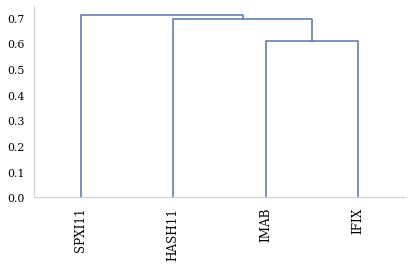

In [102]:
from pypfopt import plotting

plotting.plot_dendrogram(
    hrp=hrp,
    ax=None,
    show_tickers=True
);

### Global Minimum Variance (GMV) Portfolio e a Fronteira Eficiente

Note que as otimizações acima, com exceção da HRP, necessitam dos retornos esperados dos ativos que compõem o portfólio. É possível mostrar que uma leve alteração da entrada dos retornos esperados nos fornece uma mudança significativa dos pesos. Isso sendo um grande ponto negativo da teoria. Por outro lado, a matriz de covariância esperada (futura, no caso, de Ledoit-Wolf) não se afastará de forma expressiva da histórica (passada), sendo ela um parâmetro mais confiável.

A teoria nos permite obter um portfólio somente com a matriz de covariância esperada, chamado de *Global Minimum Variance Portfolio*. Este não está incluso na biblioteca *pyportfolio*, mas no módulo quant_tools trago o método `gmv(cov)` que recebe uma matriz de covariância `cov` e retorna os pesos do portfólio GMV, sendo a otimização realizada pela biblioteca scipy.stats. Neste mesmo módulo, trago o método `maximize_sr(exp_rets, cov, risk_free_rate)`, que recebe os retornos esperados, matriz de covariância e a taxa livre de risco, realiza a otimização pela scipy.stats e retorna os pesos. Tais portfólios podem ser confrontados com as otimizações acima.

Na verdade, a otimização pelo scipy.stats nos permite efetivamente construir a fronteira eficiente, plotada logo abaixo. A fronteira representa os portfólios que, para um dado valor de retorno, possui a mínima volatilidade. Indo mais longe, ao adicionarmos o ativo livre de risco (Selic), atualizamos a fronteira para a reta que conecta este ponto (de volatilidade zero) com o ponto tangente à fronteira inicial. O portfólio representado por este último ponto é aquele encontrado pelo método `maximize_sr`, sendo este o único ponto da fronteira que realmente temos interesse. Todas essas informações podem ser vistas no plot abaixo, juntamente com o portfólio de pesos iguais.

Analogamente às demais otimizações, com os pesos obtidos, construímos novos objetos `Portfolio`.

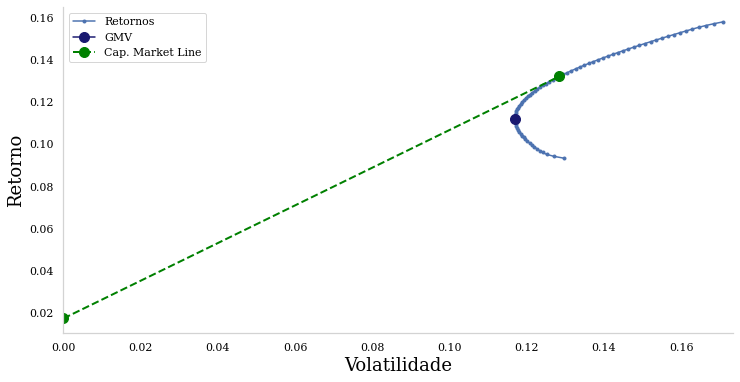

In [86]:
qt.plot_eff(
    exp_rets=ret_past_ema,
    cov=lwcov_fut,
    n_points=75,
    risk_free_rate=selic_a_fut,
    show_cml=True,
    show_gmv=True,
    is_return=True
)
plt.legend(loc=2);

In [103]:
pesos_gmv = qt.gmv(lwcov_fut)
pesos_max_sr_2 = qt.maximize_sr(ret_past_ema, lwcov_fut, selic_a_past)

In [104]:
etfs_gmv = etfs_fut_pf.transfer(
    'GMV',
    pesos_gmv
)
del pesos_gmv

print(
      f'Beta da carteira {etfs_gmv.name}: '
      f'{round(etfs_gmv.beta(ibvp_fut_pf), 6)}\n'
)

qt.comparison(
      vol_opt=etfs_gmv.volatility(),
      vol_eq=etfs_fut_pf.volatility(),
      ret_opt=etfs_gmv.portfolio_return(),
      ret_eq=etfs_fut_pf.portfolio_return(),
      risk_free_rate=selic_a_fut
)

Beta da carteira GMV: 0.22404

Volatlidade com os pesos otimizados: 10.280000000000001 %
Volatilidade com os pesos iguais: 16.37 %
Diferença percentual: + 37.2022 %

Retorno com os pesos otimizados: 2.97 %
Retorno com os pesos iguais: 24.88 %
Diferença percentual: - 88.0627 %

Índice de Sharpe com os pesos otimizados: 0.1187
Índice de Sharpe com os pesos iguais: 1.413 
Diferença percentual: - 91.5994 %



Vemos que de fato esta otimização resulta num portfólio de baixa volatilidade.

In [115]:
etfs_gmv.volatilities(is_portfolio=True)

,Volatilidade
Diária,0.006477
Mensal,0.029683
Anual,0.102825


In [105]:
etfs_opt_max_sr_2 = etfs_fut_pf.transfer(
    'Opt. Max. Sharpe 2',
    pesos_max_sr_2
)
del pesos_max_sr_2

print(
      f'Beta da carteira {etfs_opt_max_sr_2.name}: '
      f'{round(etfs_opt_max_sr_2.beta(ibvp_fut_pf), 6)}\n'
)

qt.comparison(
      vol_opt=etfs_opt_max_sr_2.volatility(),
      vol_eq=etfs_fut_pf.volatility(),
      ret_opt=etfs_opt_max_sr_2.portfolio_return(),
      ret_eq=etfs_fut_pf.portfolio_return(),
      risk_free_rate=selic_a_fut
)

Beta da carteira Opt. Max. Sharpe 2: 0.241187

Volatlidade com os pesos otimizados: 11.92 %
Volatilidade com os pesos iguais: 16.37 %
Diferença percentual: + 27.1839 %

Retorno com os pesos otimizados: -2.1 %
Retorno com os pesos iguais: 24.88 %
Diferença percentual: - 108.4405 %

Índice de Sharpe com os pesos otimizados: -0.3229
Índice de Sharpe com os pesos iguais: 1.413 
Diferença percentual: - 122.8521 %



In [112]:
# armazenando os Portfolios em disco
ps = (
    (etfs_opt_min_vol, 'etfs_opt_min_vol'),
    (etfs_opt_max_sr, 'etfs_opt_max_sr'),
    (etfs_min_risk_ret, 'etfs_min_risk_ret'),
    (etfs_hrp, 'etfs_hrp'),
    (etfs_gmv, 'etfs_gmv'),
    (etfs_opt_max_sr_2, 'etfs_opt_max_sr_2')
)

for p in ps:
    jl.dump(p[0], f'future/{p[1]}_pf.pkl')

In [47]:
# ao carregá-los diretamente, a etapa de otimização acima pode ser
# pulada

etfs_opt_min_vol = jl.load('future/etfs_opt_min_vol_pf.pkl')
Portfolio.register(etfs_opt_min_vol)

etfs_opt_max_sr = jl.load('future/etfs_opt_max_sr_pf.pkl')
Portfolio.register(etfs_opt_max_sr)

etfs_min_risk_ret = jl.load('future/etfs_min_risk_ret_pf.pkl')
Portfolio.register(etfs_min_risk_ret)

etfs_hrp = jl.load('future/etfs_hrp_pf.pkl')
Portfolio.register(etfs_hrp)

etfs_gmv = jl.load('future/etfs_gmv_pf.pkl')
Portfolio.register(etfs_gmv)

etfs_opt_max_sr_2 = jl.load('future/etfs_opt_max_sr_2_pf.pkl')
Portfolio.register(etfs_opt_max_sr_2)

### Comparação

Com todos os portfólios instanciados, usufruímos dos métodos de classe: `all_rets()`, `all_vols()`, e `all_sindex()` para computarmos todas essas quantidades com todos os portfólios. Criamos um plot com os valores registrados para retornos, volatilidade e índice de Sharpe, onde, em azul (vermelho), indicamos que o portfólio demonstra a métrica em nível mais favorável, ou seja, o retorno e o índice de Sharpe estarão em azul (vermelho) se forem **maior** (**menor**) que o portfólio de referência. Para a volatilidade, porém, temos o contrário, pois menor volatilidade indica um portfólio mais seguro.

In [107]:
rets = Portfolio.all_rets()[4:]
vols = Portfolio.all_vols()[4:]
sharpes = Portfolio.all_sindex(selic_a_fut)[4:]

ret_cores = map(
    lambda r: 'red' if r < etfs_fut_pf.portfolio_return() else 'blue',
    rets
)

vol_cores = map(
    lambda v: 'blue' if v < etfs_fut_pf.volatility() else 'red',
    vols
)

sharpe_cores = map(
    lambda s: 'red' if s < etfs_fut_pf.s_index(selic_a_fut) else 'blue',
    sharpes
)

colors = {
    'rets': list(ret_cores),
    'vols': list(vol_cores),
    'sharpes': list(sharpe_cores)
}

# como a imagem do plotly não é renderizada no github,
# insiro o png da mesma
qt.plot_opt_comparisons(rets, vols, sharpes, colors)

![picture](pictures/comparison.png)

Com o método `all_metrics([portfolios])`, sendo o argumento uma lista de portfólios, conseguimos todas as métricas até aqui obtidas para todos os portfólios da lista; assim tornando a comparação entre eles imediata. A lista definida abaixo também nos auxilia para o benchmark.

In [108]:
port_comparison = [
    ibvp_fut_pf, etfs_fut_pf, etfs_sim_min_vol,
    etfs_sim_max_sr, etfs_opt_min_vol, etfs_opt_max_sr,
    etfs_min_risk_ret, etfs_hrp,
    etfs_gmv, etfs_opt_max_sr_2
]

Portfolio.all_metrics(
    portfolios=port_comparison,
    risk_free_rate=selic_a_fut,
    window=21,
    benchmark=ibvp_fut_pf
)

,IBVP_Fut,ETFs_Fut,Sim. Min. Vol.,Sim. Max. Sharpe,Opt. Min. Vol.,Opt. Max. Sharpe,Min. Risk Ret. 25%,HRP,GMV,Opt. Max. Sharpe 2
Retorno anual,-0.056431,0.248798,0.038445,0.037797,0.225948,0.200061,0.224895,-0.024015,0.029692,-0.021016
Volatilidade anual,0.350492,0.16372,0.114996,0.117555,0.146488,0.153603,0.146715,0.114707,0.102825,0.119163
Ind. Sharpe,-0.210918,1.412797,0.182183,0.172705,1.423006,1.188559,1.413623,-0.361876,0.118619,-0.323174
Ind. Sortino,-0.241727,1.630708,0.157856,0.150894,1.548383,1.246897,1.535309,-0.320733,0.11138,-0.285481
Beta,1.0,0.288612,0.246236,0.249549,0.280898,0.290876,0.281304,0.23457,0.22404,0.241187
Skewness,-1.030063,-0.492891,-4.217781,-4.34156,-0.914065,-1.584284,-0.942003,-4.82607,-2.650837,-4.90024
Ex_Curtose,10.348595,12.668246,46.11928,47.459891,17.823924,18.200977,17.801779,55.574886,34.226131,57.131558
VaR 99.9 (d),0.143609,0.065087,0.072326,0.074436,0.063047,0.072872,0.063447,0.073797,0.057614,0.076922
CVaR 99.9 (d),0.147797,0.076786,0.078842,0.081849,0.076076,0.079654,0.076221,0.08699,0.060334,0.091299
Max. Drawdown (21),-0.44522,-0.204838,-0.207435,-0.213596,-0.197893,-0.225047,-0.199007,-0.212627,-0.172928,-0.223451


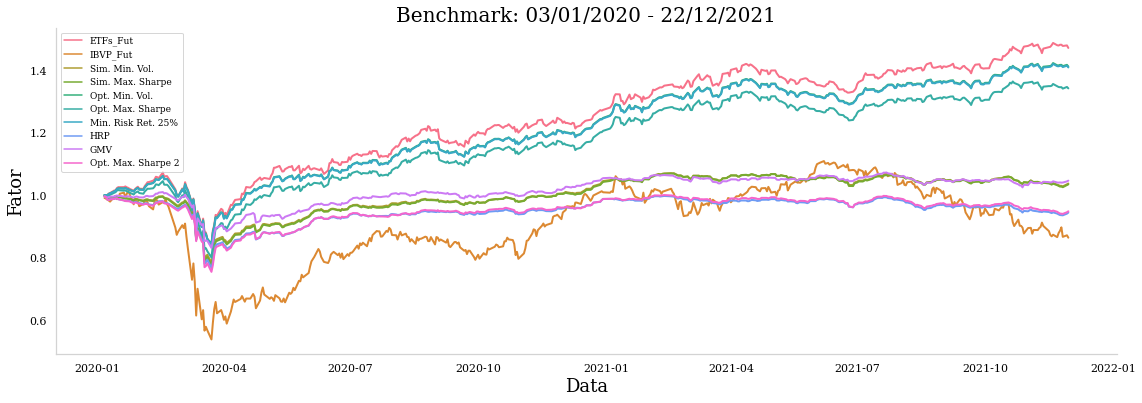

In [109]:
port_comparison.pop(1)

etfs_fut_pf.benchmark(port_comparison, is_return=True)
plt.legend(loc='upper left', fontsize=9);

Para olharmos os pesos, selecionamos das otimizações acima apenas as que apresentam índice de Sharpe maior que 1: Opt. Min. Vol., Opt. Max. Sharpe, Min. Risk. Ret. 25% e a carteira de referência, denotada por Inicial. Em particular, destacamos a de maior índice: Opt. Min. Vol, reduzindo a exposição em SPXI11 e alocando em IMAB.

In [110]:
pesos = pd.DataFrame(
    {'Opt. Min. Vol.': etfs_opt_min_vol.weights,
     'Opt. Max. Sharpe': etfs_opt_max_sr.weights,
    'Min. Risk Ret. 25%': etfs_min_risk_ret.weights,
    'Inicial': etfs_fut_pf.weights}
)
pesos.index = etfs_fut_pf.tickers
pesos

,Opt. Min. Vol.,Opt. Max. Sharpe,Min. Risk Ret. 25%,Inicial
SPXI11,0.40000,0.40,0.40000,0.50
IMAB,0.38018,0.20,0.37285,0.30
IFIX,0.18982,0.37,0.19715,0.18
HASH11,0.03000,0.03,0.03000,0.02


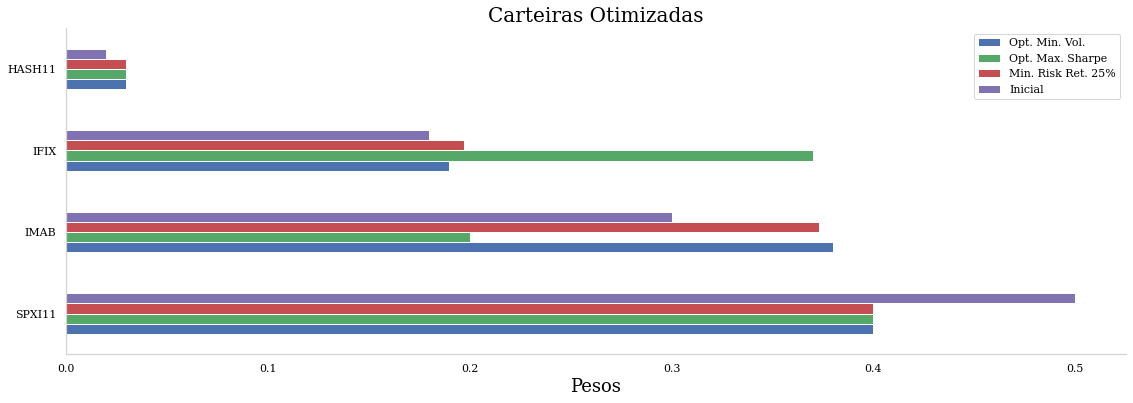

In [111]:
qt.plot_weights(pesos)

# Conclusões

A alta volatilidade dos criptoativos, 79.3% no primeiro período e 78.3% no segundo, juntamente com o efeito manada por parte dos investidores, impede o algoritmo de estimar os retornos com baixas margens de erro, o que prejudica a performance das otimizações. Por mais que nenhuma apresentou um retorno anual maior que o portfólio de referência, a **Opt. Min. Vol.** e a **Min. Risk Ret. 25%** atingiram um índice de Sharpe levemente maior, diminuindo a exposição em SPXI11 e alocando em IMAB.

É interessante analisarmos como seriam os resultados se alterarmos as restrições dos pesos ou, ainda, excluírmos o HASH11 das otimizações e o reinserirmos com um peso arbitrário, talvez entre 5% a 10%, após as mesmas. Apesar dos criptoativos apresentarem extrema volatilidade, ressaltamos que BTC e ETH são as mais resilientes, as de maior market cap e com muitas promessas para o futuro. Em compensação, para os FIIs, que foram severamente atingidos pela pandemia, é esperado uma recuperação mais lenta. Portanto, uma alocação maior em HASH11 pode trazer maiores benefícios.